# To make a .csv file from .psv file just run it once then start from library.

In [ ]:

def psv_combined(location_folder, df_obtained):
    
    
    number_of_file = 0
    total_observation = 0

    for file_name in os.listdir(location_folder):
        if file_name.endswith(".psv"):
            full_file_path = os.path.join(location_folder, file_name)
            patient_identifier = file_name.split("p")[1].split(".")[0]
            
            present_df = pd.read_csv(full_file_path, sep="|")
            
            present_df['ID_person'] = patient_identifier
            
            present_df = present_df.reset_index().rename(columns={"index": "Hour"})
            
            df_obtained = pd.concat([df_obtained, present_df], ignore_index=True)
            
            total_observation += len(present_df)
            number_of_file += 1

    return df_obtained


In [ ]:

psv_file_location = 'E:/Dissertation/SEPSIS/Dataset/training_setA/training'



current_df_psv_func = pd.DataFrame()

In [ ]:
data_incorporated = psv_combined(psv_file_location,current_df_psv_func)

In [ ]:
data_incorporated.to_csv('data_csv_A.csv')

## From here main code starts when I have "data_csv_A" in my current directory

In [82]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import scipy.stats as stats
import warnings

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    roc_auc_score, mean_absolute_error, mean_squared_error, roc_curve, auc,
    make_scorer
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    KBinsDiscretizer, FunctionTransformer, StandardScaler, OrdinalEncoder
)
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    train_test_split, GridSearchCV, GroupShuffleSplit, cross_validate,
    RandomizedSearchCV, StratifiedKFold, GroupKFold, cross_val_score
)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.neighbors import KNeighborsClassifier

# Handling warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
warnings.filterwarnings('ignore')

# Magic command for inline plotting
%matplotlib inline

!pip install imbalanced-learn
!pip install hvplot
!pip install shap

In [2]:
data_csv_A = pd.read_csv('E:/Dissertation/SEPSIS/Dataset/data_csv_A.csv')

In [3]:
data_csv_A.head()

,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,ID_person
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,83.14,0,NaN,NaN,-0.03,1,0,1
1,1,1,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,...,NaN,NaN,83.14,0,NaN,NaN,-0.03,2,0,1
2,2,2,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,...,NaN,NaN,83.14,0,NaN,NaN,-0.03,3,0,1
3,3,3,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,...,NaN,NaN,83.14,0,NaN,NaN,-0.03,4,0,1
4,4,4,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,...,NaN,NaN,83.14,0,NaN,NaN,-0.03,5,0,1


In [4]:
data_csv_A.shape

(790215, 44)

In [5]:
data_csv_A.dtypes

Unnamed: 0            int64
Hour                  int64
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
DBP                 float64
Resp                float64
EtCO2               float64
BaseExcess          float64
HCO3                float64
FiO2                float64
pH                  float64
PaCO2               float64
SaO2                float64
AST                 float64
BUN                 float64
Alkalinephos        float64
Calcium             float64
Chloride            float64
Creatinine          float64
Bilirubin_direct    float64
Glucose             float64
Lactate             float64
Magnesium           float64
Phosphate           float64
Potassium           float64
Bilirubin_total     float64
TroponinI           float64
Hct                 float64
Hgb                 float64
PTT                 float64
WBC                 float64
Fibrinogen          float64
Platelets           

In [6]:
data_csv_A.describe(datetime_is_numeric=True , include="all")

,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,ID_person
count,790215.00000,790215.000000,729026.000000,695136.000000,266901.000000,670014.000000,709357.000000,409918.000000,712957.00000,0.0,...,6030.000000,51499.000000,790215.000000,790215.000000,404050.000000,404050.000000,790207.000000,790215.000000,790215.000000,790215.000000
mean,395107.00000,25.332445,84.985264,97.265688,37.026737,120.962359,78.767345,59.985809,18.77346,NaN,...,292.251642,199.617841,63.016780,0.577721,0.507101,0.492899,-52.025757,27.198518,0.021685,10192.652564
std,228115.56582,27.954160,16.940431,2.908794,0.780317,21.520567,15.044038,12.572771,5.39575,NaN,...,158.632042,109.244146,16.133632,0.493923,0.499950,0.499950,155.864937,28.190940,0.145654,5893.668065
min,0.00000,0.000000,20.000000,20.000000,20.900000,22.000000,20.000000,20.000000,1.00000,NaN,...,34.000000,5.000000,18.110000,0.000000,0.000000,0.000000,-3710.660000,1.000000,0.000000,1.000000
25%,197553.50000,9.000000,73.000000,96.000000,36.560000,105.000000,68.000000,51.000000,15.00000,NaN,...,184.000000,127.000000,52.740000,0.000000,0.000000,0.000000,-38.090000,11.000000,0.000000,5074.000000
50%,395107.00000,20.000000,84.000000,98.000000,37.060000,118.500000,77.000000,58.500000,18.00000,NaN,...,250.000000,181.000000,65.250000,1.000000,1.000000,0.000000,-2.600000,21.000000,0.000000,10174.000000
75%,592660.50000,33.000000,96.000000,99.500000,37.550000,134.000000,87.330000,67.000000,22.00000,NaN,...,356.750000,247.000000,75.890000,1.000000,1.000000,1.000000,-0.020000,35.000000,0.000000,15284.000000
max,790214.00000,335.000000,280.000000,100.000000,42.220000,281.000000,300.000000,298.000000,69.00000,NaN,...,1760.000000,1783.000000,89.000000,1.000000,1.000000,1.000000,23.990000,336.000000,1.000000,20643.000000


In [7]:
missing_values_data_csv_A = data_csv_A.isnull().sum()
total_values_data_csv_A = len(data_csv_A)
percent_missing_value = (missing_values_data_csv_A / total_values_data_csv_A) * 100

missing_values_data_csv_A = percent_missing_value[percent_missing_value > 0].sort_values(ascending=False)
missing_values_data_csv_A

EtCO2               100.000000
TroponinI            99.877881
Bilirubin_direct     99.850420
Fibrinogen           99.236917
Bilirubin_total      98.773372
Alkalinephos         98.540650
AST                  98.504205
Lactate              96.565112
PTT                  95.152459
SaO2                 95.044387
Calcium              95.024392
Phosphate            94.951247
Platelets            93.482913
Creatinine           93.357884
WBC                  92.489639
Magnesium            92.219712
HCO3                 91.949406
BUN                  91.840702
Chloride             91.676063
PaCO2                91.231753
Hgb                  91.164303
BaseExcess           89.574863
Potassium            89.137640
pH                   88.532868
Hct                  88.223711
Glucose              87.768392
FiO2                 85.807027
Temp                 66.224255
Unit2                48.868346
Unit1                48.868346
DBP                  48.125763
SBP                  15.211177
O2Sat   

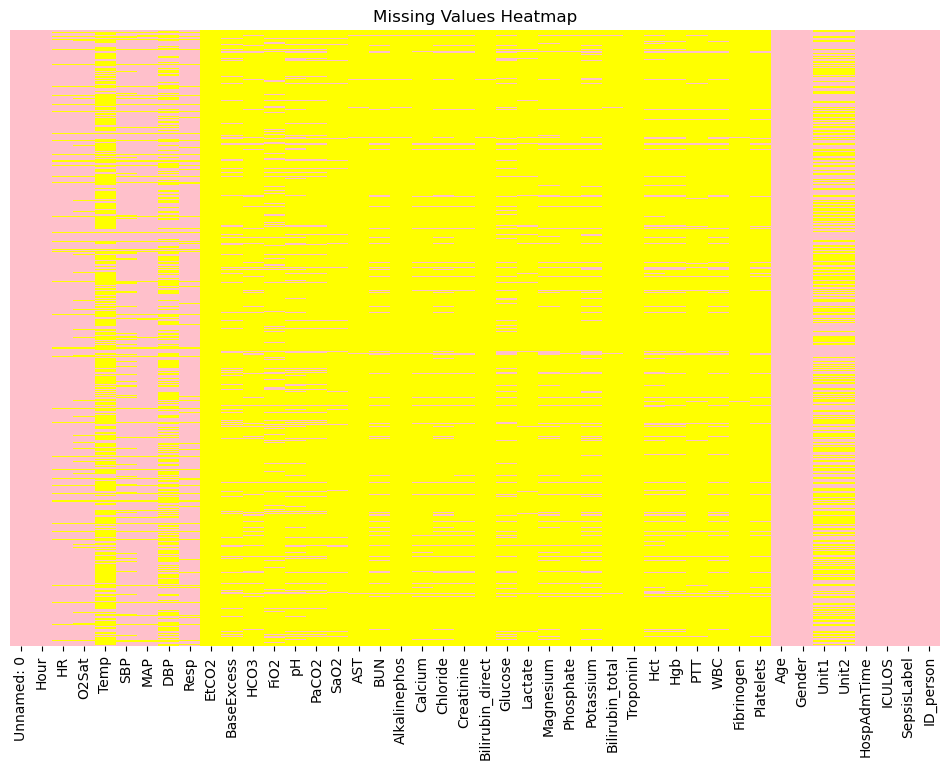

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

missing_matrix = data_csv_A.isnull().astype(int)

plt.figure(figsize=(12, 8))

cmap = sns.color_palette(["pink", "yellow"])

sns.heatmap(missing_matrix, cmap=cmap, cbar=False, yticklabels=False)

plt.title('Missing Values Heatmap')
plt.show()

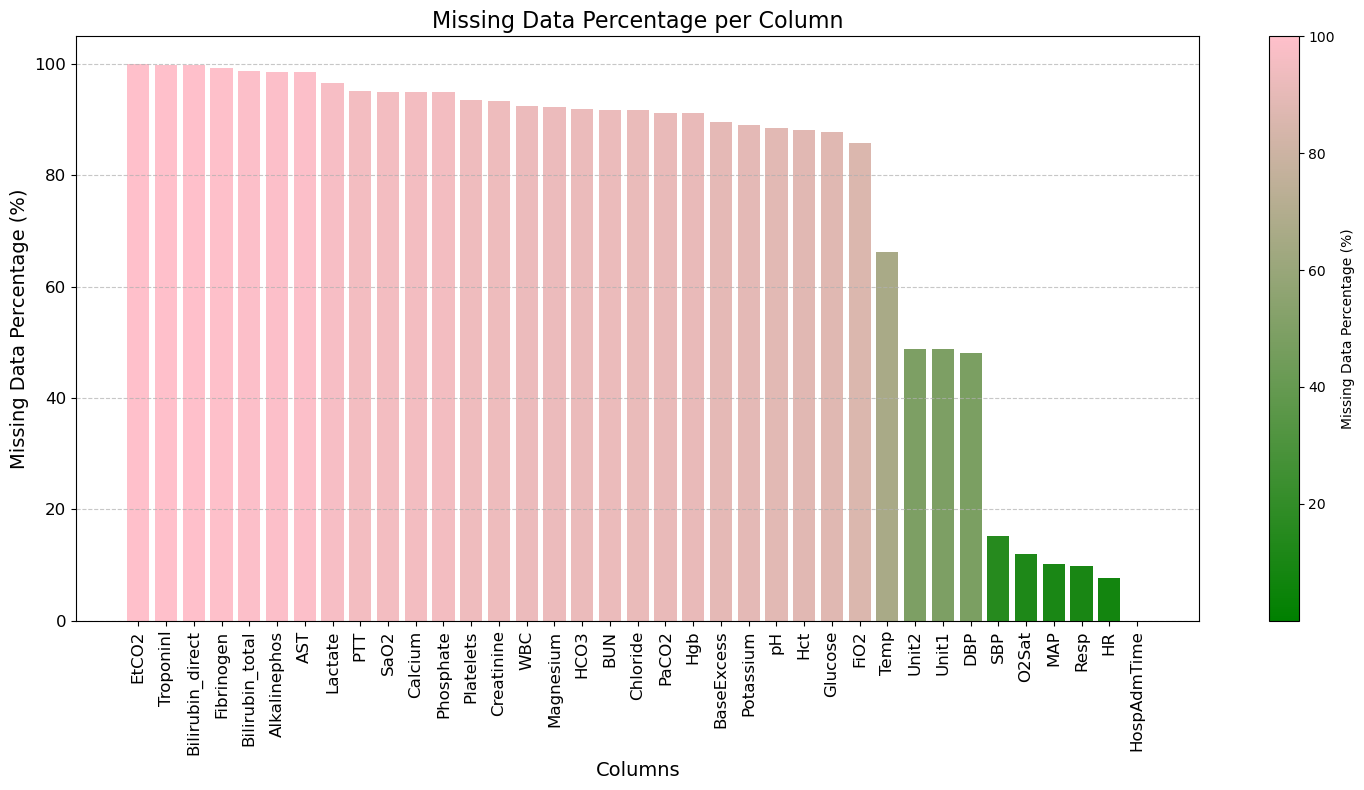

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

colors = [(0, "green"), (1, "pink")]  
cmap_custom = mcolors.LinearSegmentedColormap.from_list("custom", colors)

norm = mcolors.Normalize(vmin=missing_values_data_csv_A.min(), vmax=missing_values_data_csv_A.max())

bar_colors = [cmap_custom(norm(value)) for value in missing_values_data_csv_A]

plt.figure(figsize=(15, 8))
bars = plt.bar(missing_values_data_csv_A.index, missing_values_data_csv_A.values, color=bar_colors)
plt.xlabel("Columns", fontsize=14)
plt.ylabel("Missing Data Percentage (%)", fontsize=14)
plt.title("Missing Data Percentage per Column", fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap_custom), label="Missing Data Percentage (%)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("E:/Dissertation/SEPSIS/missing_values_percentage.png", dpi=300)
plt.show()

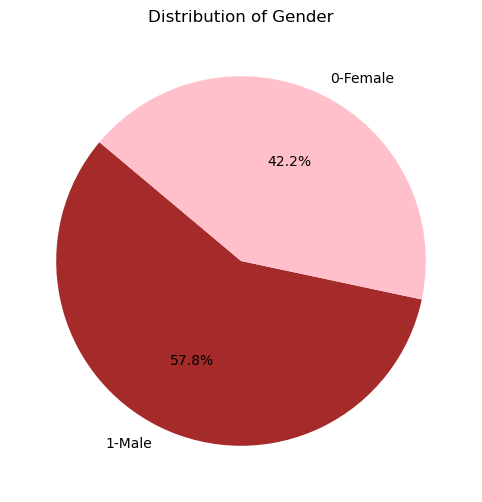

In [10]:
import matplotlib.pyplot as plt

gender_counts = data_csv_A['Gender'].value_counts()

labels = ['0-Female' if gender == 0 else '1-Male' for gender in gender_counts.index]
colors = ['pink' if gender == 0 else 'brown' for gender in gender_counts.index]

plt.figure(figsize=(8, 6))
plt.pie(gender_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Gender')
plt.show()

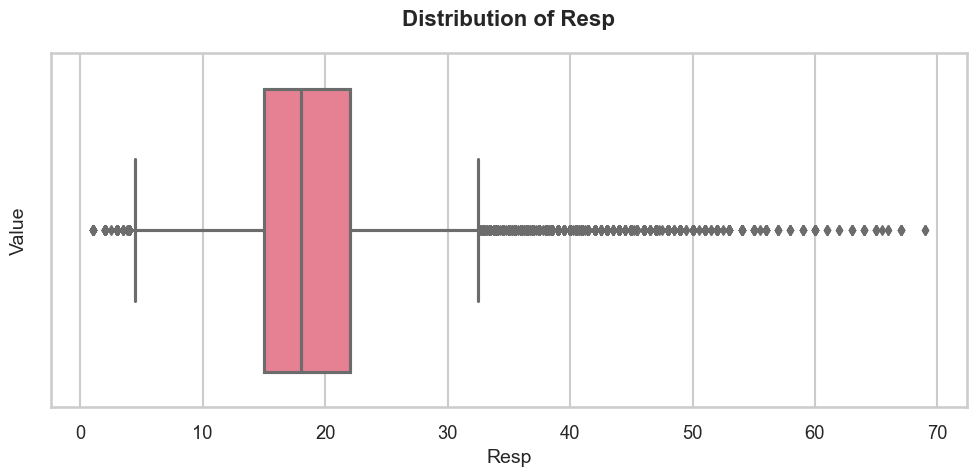

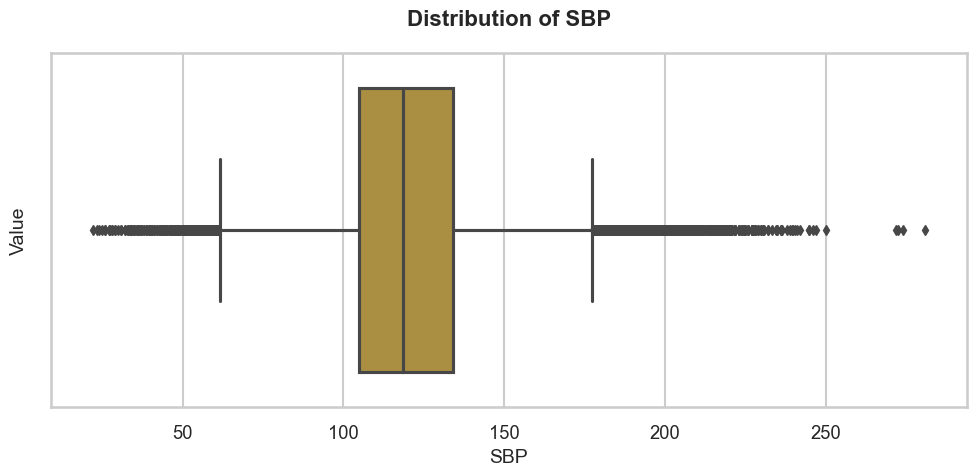

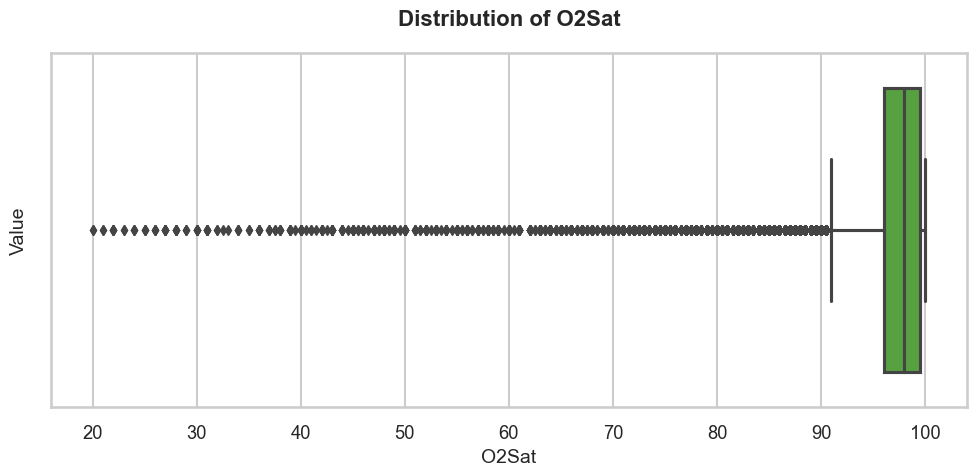

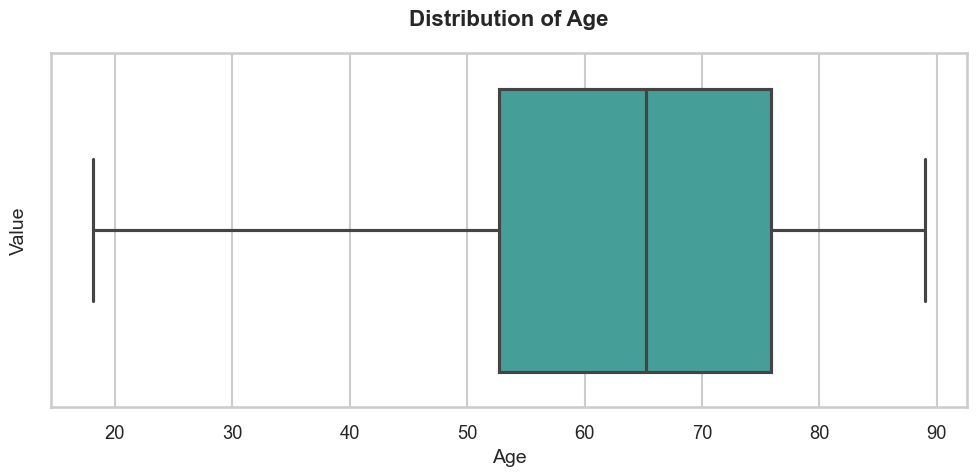

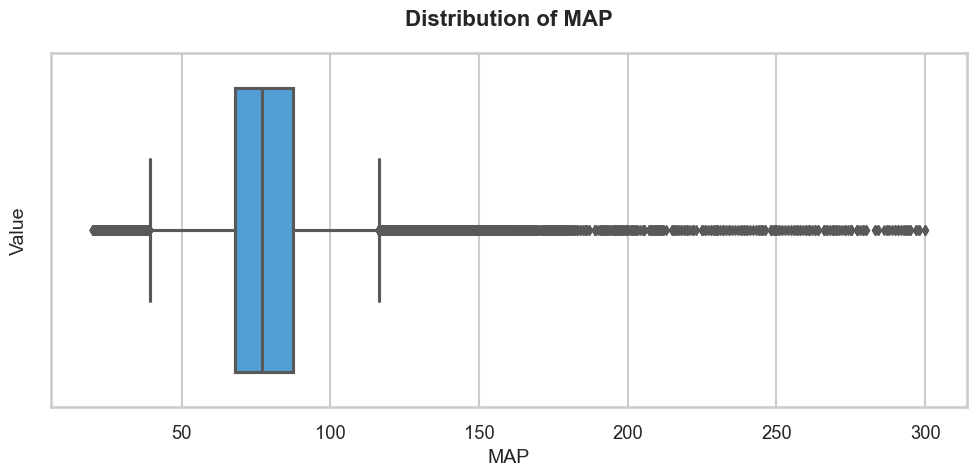

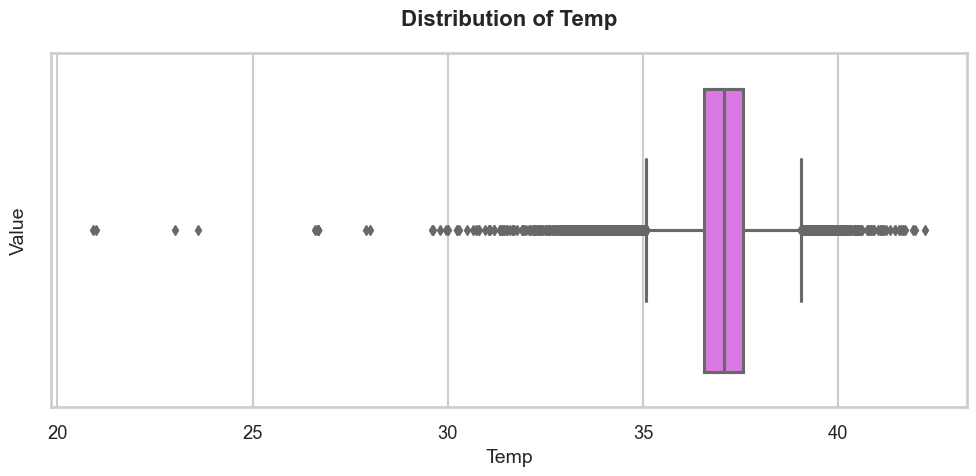

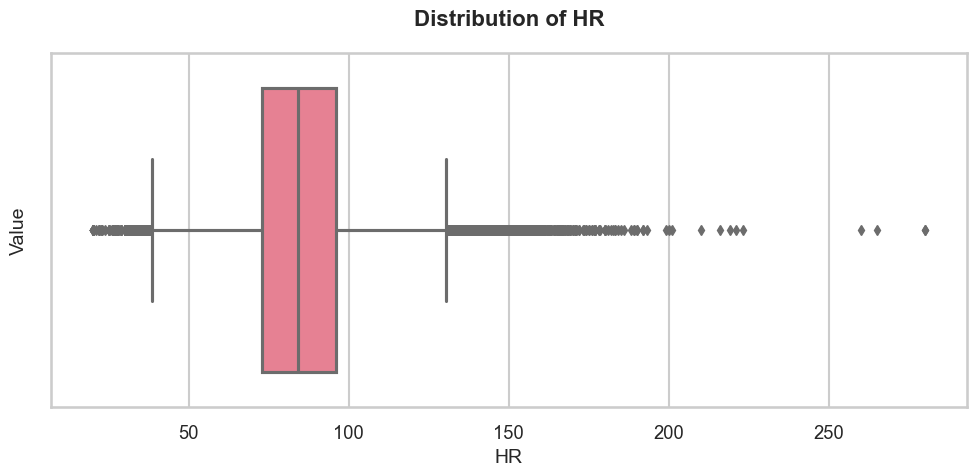

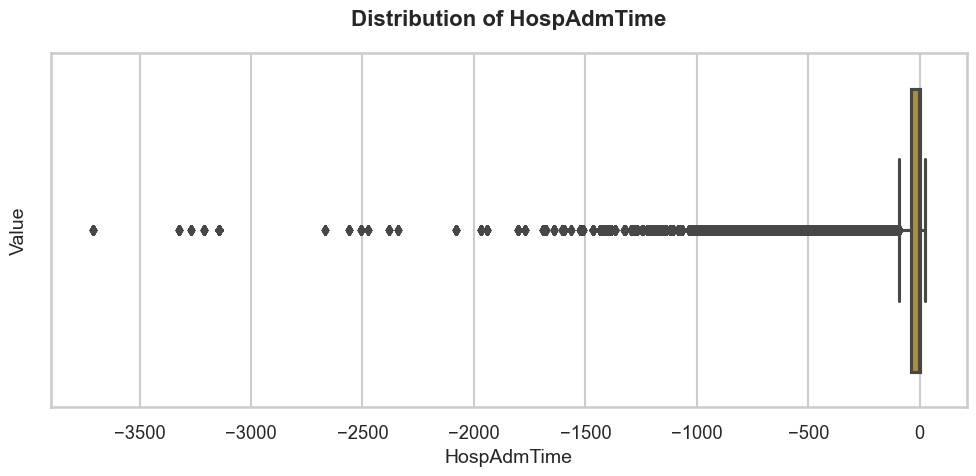

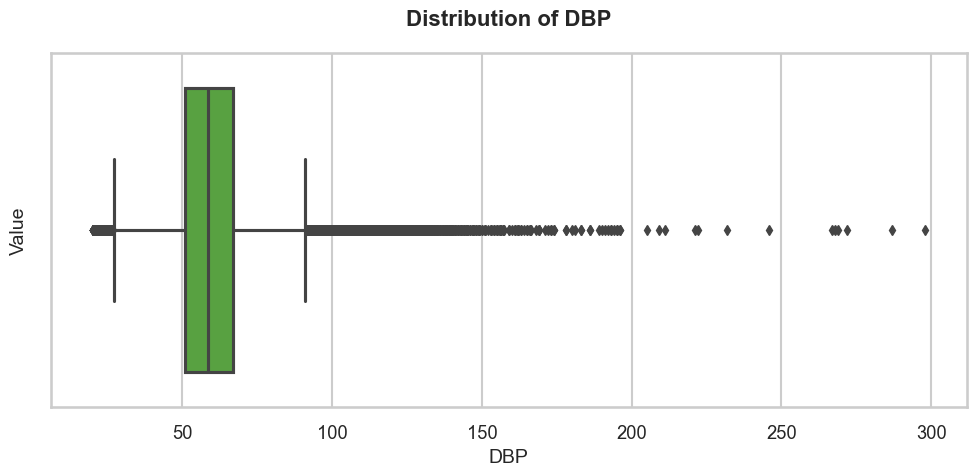

In [11]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

os.makedirs('plots', exist_ok=True)

sns.set_style('whitegrid')
sns.set_context('talk', font_scale=0.8)

color_palette = sns.color_palette('husl')

numerical_measurements = ['Resp', 'SBP', 'O2Sat', 'Age', 'MAP', 'Temp', 'HR', 'HospAdmTime', 'DBP']  

i = 0
for idx, var in enumerate(numerical_measurements):
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=data_csv_A[var], color=color_palette[idx % len(color_palette)])
    
    plt.title(f'Distribution of {var}', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel(var, fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.tight_layout()
    i += 1
    plt.savefig(f"plots/BoxPlot{i}.png")
    plt.show()

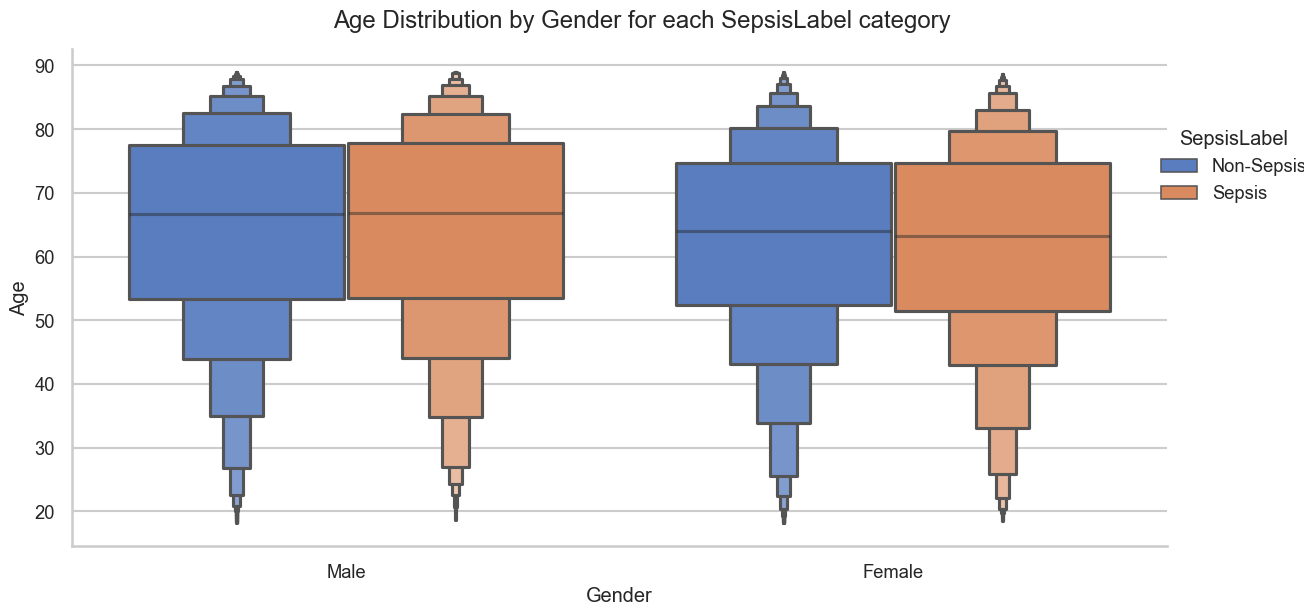

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

cat_plot = sns.catplot(data=data_csv_A, kind="boxen", x='Gender', y='Age', hue='SepsisLabel', 
                       palette="muted", height=6, aspect=2)

cat_plot.fig.suptitle('Age Distribution by Gender for each SepsisLabel category', y=1.03)
cat_plot.set_xlabels('Gender')
cat_plot.set_ylabels('Age')

cat_plot.set_xticklabels(['Male', 'Female'])

cat_plot._legend.set_title('SepsisLabel')
cat_plot._legend.set_bbox_to_anchor((1, 0.75))  # Adjust the position of the legend
for t, l in zip(cat_plot._legend.texts, ['Non-Sepsis', 'Sepsis']): t.set_text(l)

i += 1

cat_plot.savefig(f"plots/Plot{i}.png")



In [13]:
no_of_persons = data_csv_A['ID_person'].nunique()
no_of_persons

20336

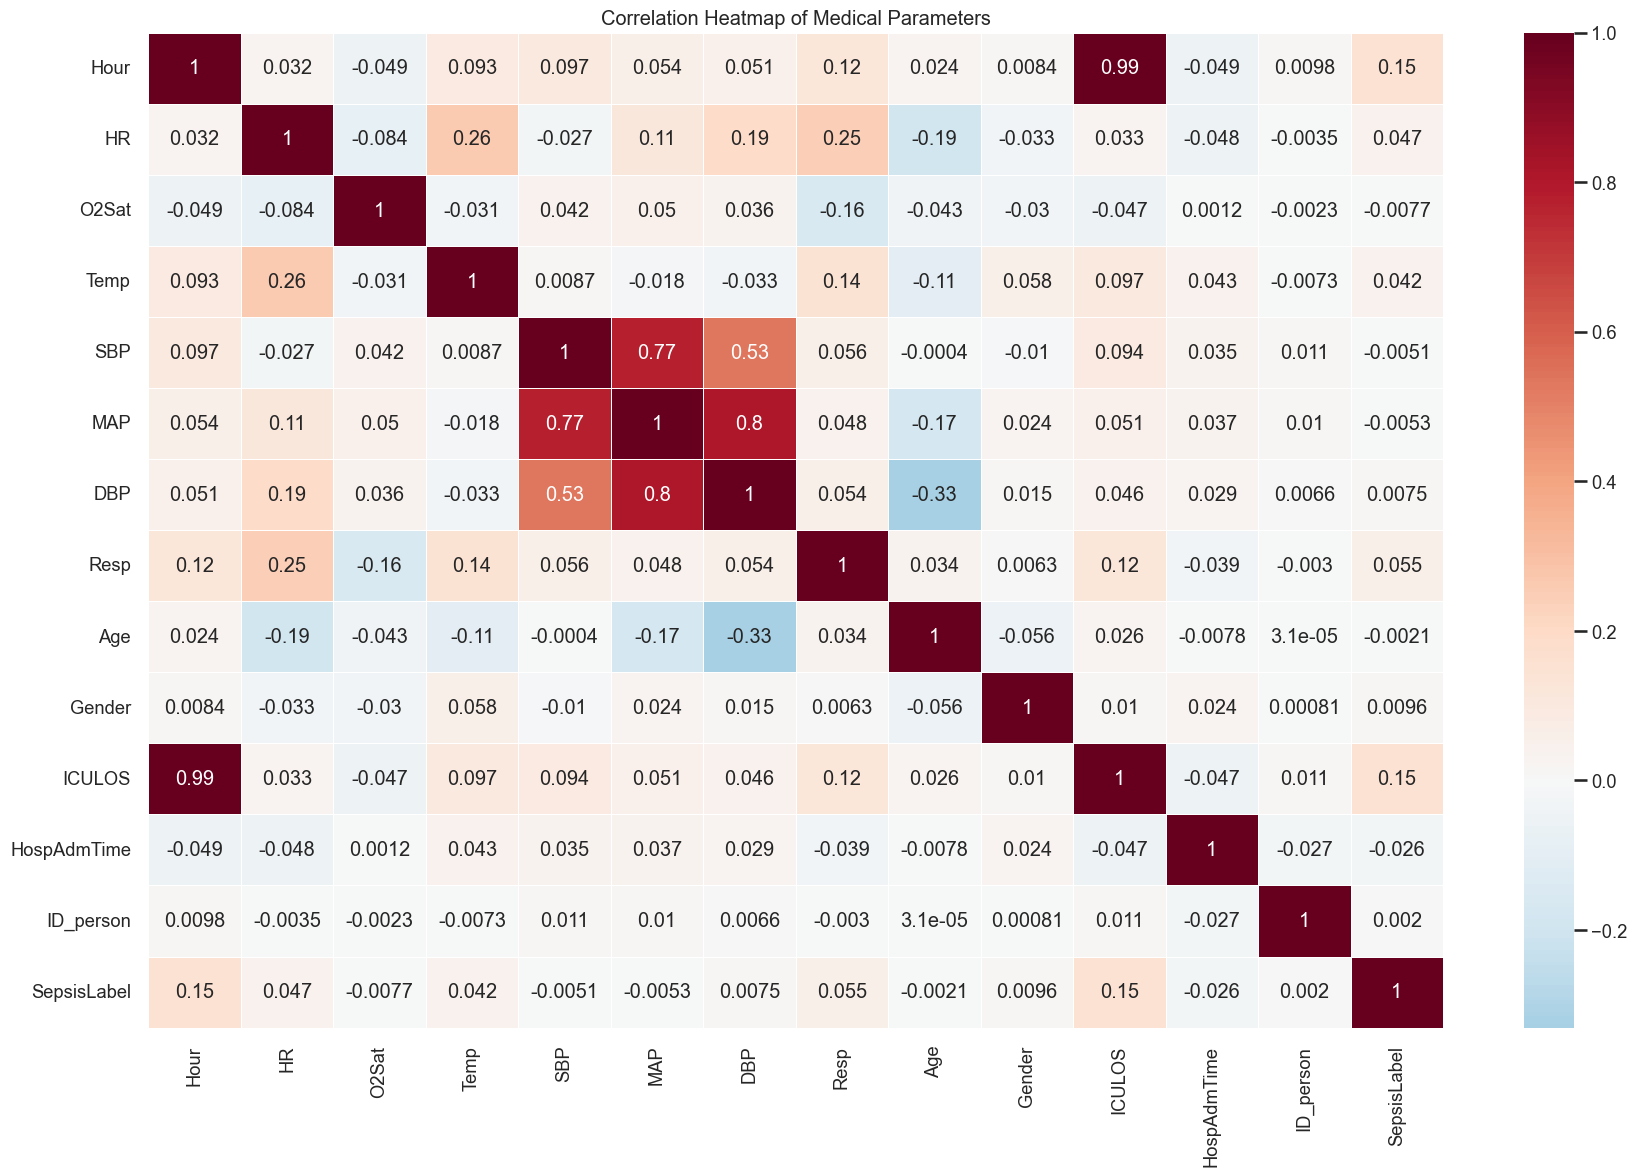

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


chosen_columns = [
    'Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp',
    'Age', 'Gender', 'ICULOS', 'HospAdmTime', 'ID_person','SepsisLabel'
]
data_subset = data_csv_A[chosen_columns]

correlation_data = data_subset.corr()

plt.figure(figsize=(18, 12))
sns.heatmap(correlation_data, annot=True, cmap='RdBu_r', linewidths=0.5, center=0)
plt.title("Correlation Heatmap of Medical Parameters")
plt.tight_layout()
plt.show()

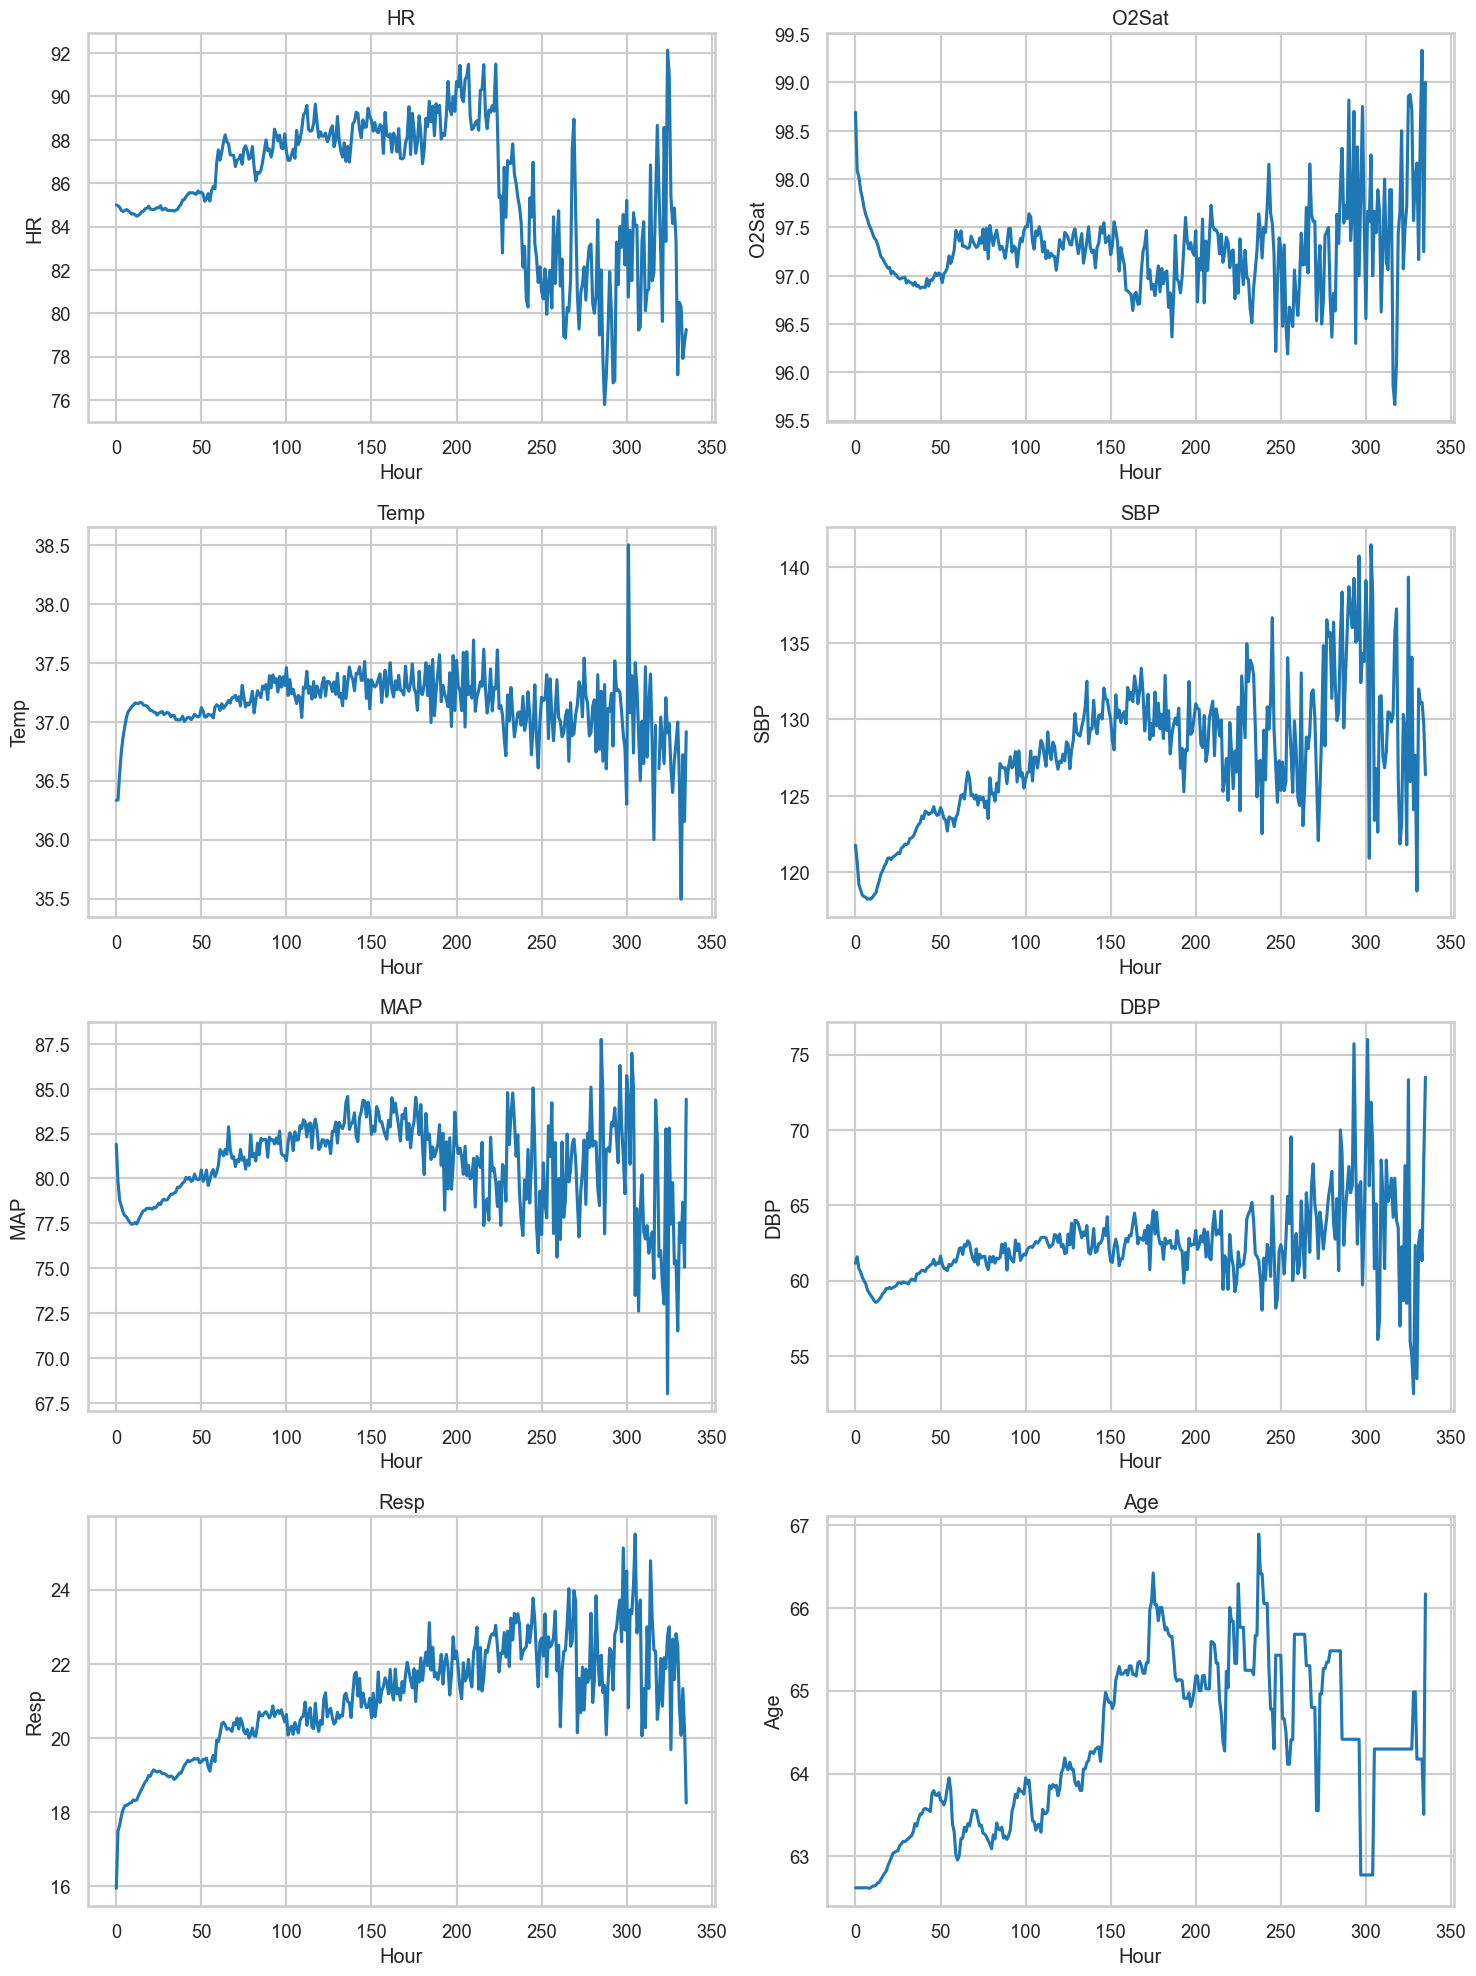

In [15]:
import pandas as pd
import matplotlib.pyplot as plt


variables_to_plot = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'Age']

n_rows = len(variables_to_plot) // 2 + len(variables_to_plot) % 2

fig, axs = plt.subplots(n_rows, 2, figsize=(15, n_rows * 5))

axs = axs.flatten()

for ax in axs[len(variables_to_plot):]:
    fig.delaxes(ax)

for i, var in enumerate(variables_to_plot):
    data_csv_A.groupby('Hour')[var].mean().plot(ax=axs[i], title=var, grid=True)
    axs[i].set_xlabel('Hour')
    axs[i].set_ylabel(var)

plt.tight_layout()
plt.show()

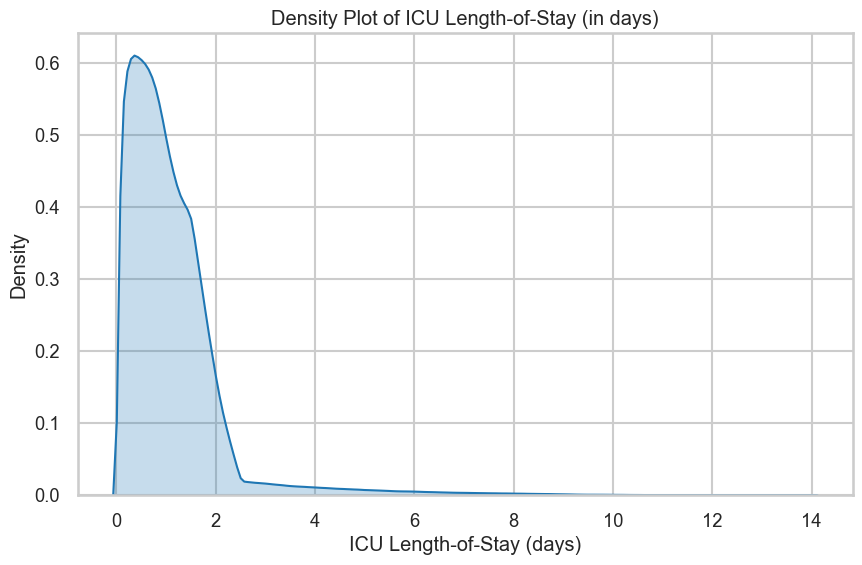

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


data_csv_A['ICULOS_days'] = data_csv_A['ICULOS'] / 24

plt.figure(figsize=(10, 6))
sns.kdeplot(data=data_csv_A, x="ICULOS_days", fill=True, bw_adjust=0.5)
plt.title('Density Plot of ICU Length-of-Stay (in days)')
plt.xlabel('ICU Length-of-Stay (days)')
plt.ylabel('Density')
plt.show()

In [17]:
new_copy_A = data_csv_A.copy()

In [18]:
type(new_copy_A)

pandas.core.frame.DataFrame

In [19]:
null_values = new_copy_A.isnull().mean() * 100
null_values_sorted = null_values.sort_values(ascending=False)
null_values_sorted

EtCO2               100.000000
TroponinI            99.877881
Bilirubin_direct     99.850420
Fibrinogen           99.236917
Bilirubin_total      98.773372
Alkalinephos         98.540650
AST                  98.504205
Lactate              96.565112
PTT                  95.152459
SaO2                 95.044387
Calcium              95.024392
Phosphate            94.951247
Platelets            93.482913
Creatinine           93.357884
WBC                  92.489639
Magnesium            92.219712
HCO3                 91.949406
BUN                  91.840702
Chloride             91.676063
PaCO2                91.231753
Hgb                  91.164303
BaseExcess           89.574863
Potassium            89.137640
pH                   88.532868
Hct                  88.223711
Glucose              87.768392
FiO2                 85.807027
Temp                 66.224255
Unit1                48.868346
Unit2                48.868346
DBP                  48.125763
SBP                  15.211177
O2Sat   

In [20]:
ID_with_sepsis = new_copy_A.loc[new_copy_A['SepsisLabel'] == 1, 'ID_person'].unique()
ID_with_sepsis

array([    9,    11,    15, ..., 20601, 20637, 20643], dtype=int64)

In [21]:
sepsis_hr_zero = new_copy_A.loc[(new_copy_A['SepsisLabel'] == 1) & (new_copy_A['Hour'] == 0), 'ID_person'].unique()
sepsis_hr_zero

array([   56,    58,   211,   260,   403,   524,   545,   616,   728,
        1118,  1178,  1272,  1384,  1433,  1466,  1625,  1912,  1993,
        2117,  2203,  2441,  2551,  2559,  2580,  2767,  2853,  2872,
        3158,  3161,  3231,  3233,  3390,  3936,  4132,  4158,  4164,
        4326,  4426,  4433,  4827,  4896,  4986,  5112,  5129,  5191,
        5198,  5328,  5438,  5500,  5688,  5876,  5925,  5987,  6046,
        6214,  6368,  6462,  6468,  6476,  6791,  6968,  7201,  7538,
        7540,  7678,  7716,  7717,  7802,  7870,  7911,  7921,  7987,
        8135,  8205,  8255,  8323,  8337,  8554,  8680,  8706,  8710,
        8737,  8781,  9023,  9215,  9398,  9435,  9441,  9558,  9594,
        9640,  9785,  9972, 10058, 10157, 10209, 10236, 10377, 10461,
       10652, 10665, 10686, 10778, 10880, 10954, 11120, 11144, 11157,
       11181, 11330, 11442, 11454, 11624, 11697, 11891, 11901, 12042,
       12138, 12541, 12732, 12775, 12784, 12786, 12889, 12964, 13003,
       13056, 13071,

In [22]:
data_of_sepsis_person = new_copy_A[new_copy_A['ID_person'].isin(ID_with_sepsis)]
data_of_sepsis_person

,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,ID_person,ICULOS_days
304,304,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,27.92,1,NaN,NaN,-0.03,1,0,9,0.041667
305,305,1,117.0,99.0,NaN,116.0,97.0,81.0,20.0,NaN,...,NaN,27.92,1,NaN,NaN,-0.03,2,0,9,0.083333
306,306,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,64.0,27.92,1,NaN,NaN,-0.03,3,0,9,0.125000
307,307,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,114.0,27.92,1,NaN,NaN,-0.03,4,0,9,0.166667
308,308,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,27.92,1,NaN,NaN,-0.03,5,0,9,0.208333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790210,790210,28,88.0,98.0,NaN,135.0,81.0,64.0,16.0,NaN,...,NaN,62.29,1,NaN,NaN,-0.03,31,1,20643,1.291667
790211,790211,29,96.0,98.0,38.72,174.0,97.0,72.0,16.0,NaN,...,NaN,62.29,1,NaN,NaN,-0.03,32,1,20643,1.333333
790212,790212,30,140.0,97.0,NaN,133.0,81.5,62.5,16.0,NaN,...,NaN,62.29,1,NaN,NaN,-0.03,33,1,20643,1.375000
790213,790213,31,120.0,96.0,NaN,154.0,118.0,105.0,16.0,NaN,...,NaN,62.29,1,NaN,NaN,-0.03,34,1,20643,1.416667


In [23]:
data_of_non_sepsis = new_copy_A[~new_copy_A['ID_person'].isin(ID_with_sepsis)]
data_of_non_sepsis

,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,ID_person,ICULOS_days
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,1,0,1,0.041667
1,1,1,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,2,0,1,0.083333
2,2,2,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,3,0,1,0.125000
3,3,3,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,4,0,1,0.166667
4,4,4,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,5,0,1,0.208333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790177,790177,37,97.0,100.0,NaN,NaN,72.00,NaN,18.0,NaN,...,NaN,69.80,0,NaN,NaN,-10.58,38,0,20642,1.583333
790178,790178,38,110.0,100.0,37.0,NaN,91.00,NaN,17.0,NaN,...,NaN,69.80,0,NaN,NaN,-10.58,39,0,20642,1.625000
790179,790179,39,114.0,100.0,NaN,NaN,89.00,NaN,21.0,NaN,...,NaN,69.80,0,NaN,NaN,-10.58,40,0,20642,1.666667
790180,790180,40,130.0,99.0,NaN,NaN,NaN,NaN,21.0,NaN,...,NaN,69.80,0,NaN,NaN,-10.58,41,0,20642,1.708333


In [24]:
sepsis_after_admission= data_of_sepsis_person[~data_of_sepsis_person['ID_person'].isin(sepsis_hr_zero)]
sepsis_after_admission

,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,ID_person,ICULOS_days
304,304,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,27.92,1,NaN,NaN,-0.03,1,0,9,0.041667
305,305,1,117.0,99.0,NaN,116.0,97.0,81.0,20.0,NaN,...,NaN,27.92,1,NaN,NaN,-0.03,2,0,9,0.083333
306,306,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,64.0,27.92,1,NaN,NaN,-0.03,3,0,9,0.125000
307,307,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,114.0,27.92,1,NaN,NaN,-0.03,4,0,9,0.166667
308,308,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,27.92,1,NaN,NaN,-0.03,5,0,9,0.208333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790210,790210,28,88.0,98.0,NaN,135.0,81.0,64.0,16.0,NaN,...,NaN,62.29,1,NaN,NaN,-0.03,31,1,20643,1.291667
790211,790211,29,96.0,98.0,38.72,174.0,97.0,72.0,16.0,NaN,...,NaN,62.29,1,NaN,NaN,-0.03,32,1,20643,1.333333
790212,790212,30,140.0,97.0,NaN,133.0,81.5,62.5,16.0,NaN,...,NaN,62.29,1,NaN,NaN,-0.03,33,1,20643,1.375000
790213,790213,31,120.0,96.0,NaN,154.0,118.0,105.0,16.0,NaN,...,NaN,62.29,1,NaN,NaN,-0.03,34,1,20643,1.416667


In [25]:
new_copy_A['category_of_sepsis'] = np.where(
    
    new_copy_A['ID_person'].isin(sepsis_after_admission['ID_person']), 'sepsis_after_admission_to_ICU',
    
    
    np.where(new_copy_A['ID_person'].isin(sepsis_hr_zero), 'sepsis_before_ICU',
    
    
    'NoSepsis')
)
new_copy_A.head

<bound method NDFrame.head of         Unnamed: 0  Hour     HR  O2Sat   Temp    SBP     MAP    DBP  Resp  \
0                0     0    NaN    NaN    NaN    NaN     NaN    NaN   NaN   
1                1     1   97.0   95.0    NaN   98.0   75.33    NaN  19.0   
2                2     2   89.0   99.0    NaN  122.0   86.00    NaN  22.0   
3                3     3   90.0   95.0    NaN    NaN     NaN    NaN  30.0   
4                4     4  103.0   88.5    NaN  122.0   91.33    NaN  24.5   
...            ...   ...    ...    ...    ...    ...     ...    ...   ...   
790210      790210    28   88.0   98.0    NaN  135.0   81.00   64.0  16.0   
790211      790211    29   96.0   98.0  38.72  174.0   97.00   72.0  16.0   
790212      790212    30  140.0   97.0    NaN  133.0   81.50   62.5  16.0   
790213      790213    31  120.0   96.0    NaN  154.0  118.00  105.0  16.0   
790214      790214    32  115.0   95.0    NaN  150.0  117.00  104.0  16.0   

        EtCO2  ...    Age  Gender  Unit1  Uni

In [26]:
number_each_category= new_copy_A['category_of_sepsis'].value_counts()
number_each_category

NoSepsis                         685251
sepsis_after_admission_to_ICU    103196
sepsis_before_ICU                  1768
Name: category_of_sepsis, dtype: int64

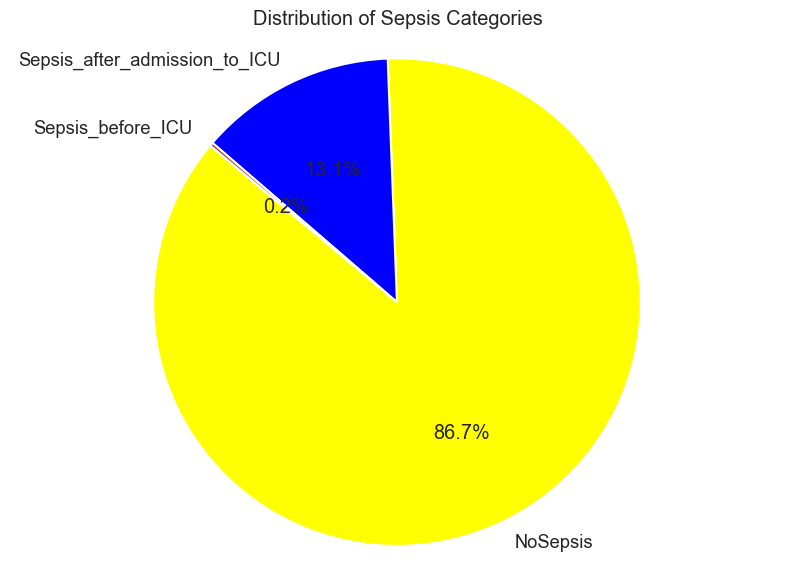

In [27]:
import matplotlib.pyplot as plt

labels = 'NoSepsis', 'Sepsis_after_admission_to_ICU', 'Sepsis_before_ICU'
sizes = [685251, 103196, 1768]
colors = ['yellow', 'blue', 'brown']

plt.figure(figsize=(10, 7))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  
plt.title('Distribution of Sepsis Categories')
plt.show()

In [28]:
new_copy_A.shape

(790215, 46)

In [29]:
def get_unique_patients_count_alternative(data):
    
    if isinstance(data, pd.DataFrame):
        patient_data = data['ID_person']
    elif isinstance(data, (pd.Series, np.ndarray)):
        patient_data = data
    else:
        raise ValueError("Input must be a pandas DataFrame, Series, or a numpy ndarray.")

    if isinstance(patient_data, np.ndarray):
        patient_data = pd.Series(patient_data)

    unique_patients = patient_data.drop_duplicates().count()
    return unique_patients

In [30]:
total_count_sepsis_after_admission = get_unique_patients_count_alternative(sepsis_after_admission)
total_count_sepsis_after_admission

1587

In [31]:
total_count_data_of_sepsis_person = get_unique_patients_count_alternative(data_of_sepsis_person)
total_count_data_of_sepsis_person

1790

In [32]:
total_person_in_hospital = get_unique_patients_count_alternative(new_copy_A)
total_person_in_hospital

20336

In [33]:
total_person_sepsis_hr_zero = get_unique_patients_count_alternative(sepsis_hr_zero)
total_person_sepsis_hr_zero

203

In [34]:
total_person_data_of_non_sepsis = get_unique_patients_count_alternative(data_of_non_sepsis)
total_person_data_of_non_sepsis

18546

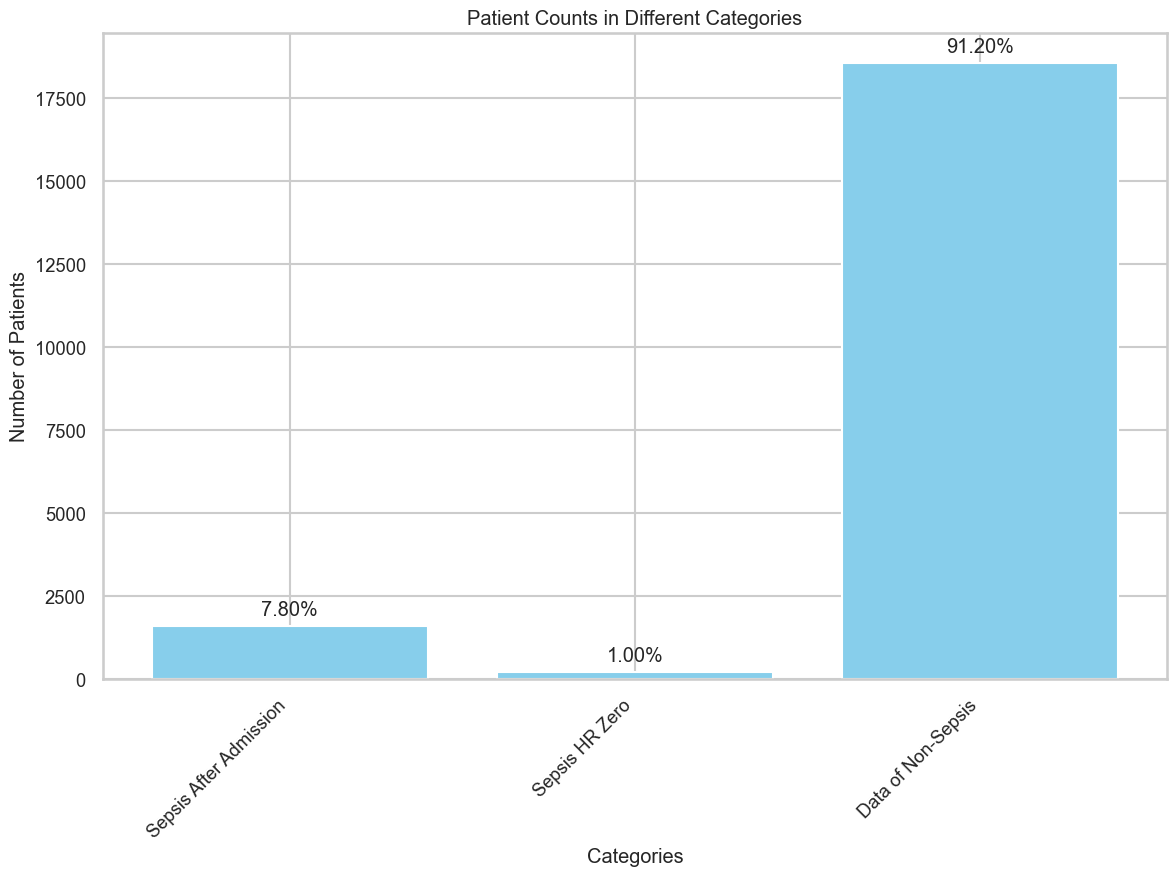

In [35]:
import matplotlib.pyplot as plt

counts = {
    "Sepsis After Admission": 1587,
    #"Data of Sepsis Person": 1790,
    #"Total Person in Hospital": 20336,
    "Sepsis HR Zero": 203,
    "Data of Non-Sepsis": 18546
}

total_count = sum(counts.values())

plt.figure(figsize=(12, 9))
bars = plt.bar(counts.keys(), counts.values(), color='skyblue')

plt.title('Patient Counts in Different Categories')
plt.xlabel('Categories')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45, ha="right")  

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01*total_count, 
             f'{100 * yval/total_count:.2f}%', ha='center', va='bottom')

plt.tight_layout()  

plt.show()


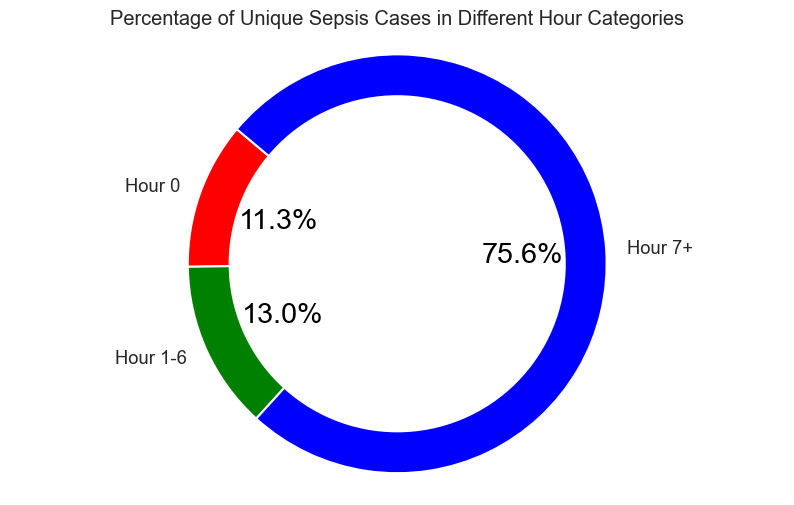

In [36]:
import matplotlib.pyplot as plt

categories_sepsis_hr = ['Hour 0', 'Hour 1-6', 'Hour 7+']

unique_sepsis_cases = new_copy_A[new_copy_A['SepsisLabel'] == 1].groupby('ID_person').first().reset_index()
hour_0_unique = unique_sepsis_cases[unique_sepsis_cases['Hour'] == 0]
hour_1_to_6_unique = unique_sepsis_cases[(unique_sepsis_cases['Hour'] >= 1) & (unique_sepsis_cases['Hour'] <= 6)]
hour_7_plus_unique = unique_sepsis_cases[unique_sepsis_cases['Hour'] >= 7]
unique_counts = [hour_0_unique.shape[0], hour_1_to_6_unique.shape[0], hour_7_plus_unique.shape[0]]

plt.figure(figsize=(10, 6))
wedges, texts, autotexts = plt.pie(unique_counts, labels=categories_sepsis_hr, colors=['red', 'green', 'blue'], autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))

plt.title('Percentage of Unique Sepsis Cases in Different Hour Categories')

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize('x-large')

centre_circle = plt.Circle((0,0),0.80,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')  

plt.show()


Explanation of why these columns have been dropped is in the report.

In [37]:
columns_being_dropped={'Unnamed: 0','SBP','DBP','EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium', 'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2','category_of_sepsis'}
new_copy_A = new_copy_A.assign(Unit=new_copy_A['Unit1'] + new_copy_A['Unit2'])
new_copy_A_modified = new_copy_A.drop(columns=columns_being_dropped)
new_copy_A_modified.columns

Index(['Hour', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'FiO2', 'SaO2', 'AST',
       'BUN', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose',
       'Lactate', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'WBC',
       'Platelets', 'Age', 'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel',
       'ID_person', 'ICULOS_days', 'Unit'],
      dtype='object')

In [38]:

def correlation_matrix_columns(df):

    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(11, 9))  # Adjust size if needed
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()  


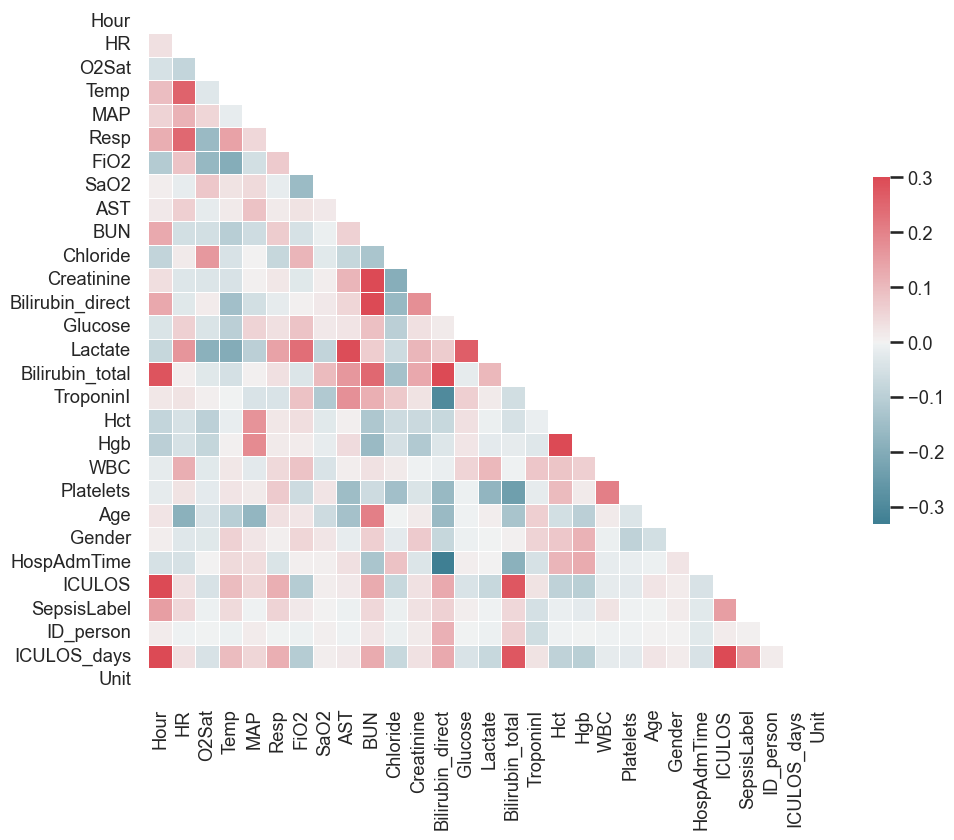

In [39]:
correlation_matrix_columns(new_copy_A_modified)

In [40]:
new_copy_A_modified.head()

,Hour,HR,O2Sat,Temp,MAP,Resp,FiO2,SaO2,AST,BUN,...,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel,ID_person,ICULOS_days,Unit
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,83.14,0,-0.03,1,0,1,0.041667,NaN
1,1,97.0,95.0,NaN,75.33,19.0,NaN,NaN,NaN,NaN,...,NaN,NaN,83.14,0,-0.03,2,0,1,0.083333,NaN
2,2,89.0,99.0,NaN,86.00,22.0,NaN,NaN,NaN,NaN,...,NaN,NaN,83.14,0,-0.03,3,0,1,0.125000,NaN
3,3,90.0,95.0,NaN,NaN,30.0,NaN,NaN,NaN,NaN,...,NaN,NaN,83.14,0,-0.03,4,0,1,0.166667,NaN
4,4,103.0,88.5,NaN,91.33,24.5,0.28,NaN,NaN,NaN,...,NaN,NaN,83.14,0,-0.03,5,0,1,0.208333,NaN


In [41]:
imputed_new_copy_A_modified = new_copy_A_modified.copy()
imputed_columns = list(imputed_new_copy_A_modified.columns)

In [42]:
per_person_data = imputed_new_copy_A_modified.groupby('ID_person')
imputed_new_copy_A_modified = per_person_data.apply(lambda x: x.bfill().ffill())

In [43]:
imputed_new_copy_A_modified.head()

,Hour,HR,O2Sat,Temp,MAP,Resp,FiO2,SaO2,AST,BUN,...,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel,ID_person,ICULOS_days,Unit
0,0,97.0,95.0,36.11,75.33,19.0,0.28,88.0,16.0,14.0,...,5.7,317.0,83.14,0,-0.03,1,0,1,0.041667,NaN
1,1,97.0,95.0,36.11,75.33,19.0,0.28,88.0,16.0,14.0,...,5.7,317.0,83.14,0,-0.03,2,0,1,0.083333,NaN
2,2,89.0,99.0,36.11,86.00,22.0,0.28,88.0,16.0,14.0,...,5.7,317.0,83.14,0,-0.03,3,0,1,0.125000,NaN
3,3,90.0,95.0,36.11,91.33,30.0,0.28,88.0,16.0,14.0,...,5.7,317.0,83.14,0,-0.03,4,0,1,0.166667,NaN
4,4,103.0,88.5,36.11,91.33,24.5,0.28,88.0,16.0,14.0,...,5.7,317.0,83.14,0,-0.03,5,0,1,0.208333,NaN


In [44]:
null_values = imputed_new_copy_A_modified.isnull().mean()*100
null_values_after = null_values.sort_values(ascending=False)
null_values_after

TroponinI           97.357934
Bilirubin_direct    96.256841
Bilirubin_total     66.949754
AST                 66.435590
SaO2                57.282891
Lactate             55.997418
Unit                48.868346
FiO2                36.195592
WBC                  1.511994
Platelets            1.394810
Chloride             1.310656
Hgb                  1.158672
Creatinine           1.029467
Glucose              0.940630
BUN                  0.937719
Temp                 0.853692
Hct                  0.779028
Resp                 0.088710
O2Sat                0.026702
MAP                  0.003037
HR                   0.001139
HospAdmTime          0.001012
Age                  0.000000
Gender               0.000000
ICULOS               0.000000
SepsisLabel          0.000000
ID_person            0.000000
ICULOS_days          0.000000
Hour                 0.000000
dtype: float64

In [45]:
mt25p_columns_removed_list = ['TroponinI', 'ID_person', 'Bilirubin_direct', 'Unit', 'Lactate', 'SaO2', 'AST', 'FiO2', 'Bilirubin_total']
imputed_new_copy_A_modified = imputed_new_copy_A_modified.drop(columns=mt25p_columns_removed_list)
imputed_new_copy_A_modified.columns

Index(['Hour', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel', 'ICULOS_days'],
      dtype='object')

In [46]:

binary_for_gender = pd.get_dummies(imputed_new_copy_A_modified['Gender'])
imputed_new_copy_A_modified = imputed_new_copy_A_modified.join(binary_for_gender)
imputed_new_copy_A_modified = imputed_new_copy_A_modified.drop('Gender', axis=1)
imputed_new_copy_A_modified.head()

,Hour,HR,O2Sat,Temp,MAP,Resp,BUN,Chloride,Creatinine,Glucose,...,Hgb,WBC,Platelets,Age,HospAdmTime,ICULOS,SepsisLabel,ICULOS_days,0,1
0,0,97.0,95.0,36.11,75.33,19.0,14.0,85.0,0.7,193.0,...,12.5,5.7,317.0,83.14,-0.03,1,0,0.041667,1,0
1,1,97.0,95.0,36.11,75.33,19.0,14.0,85.0,0.7,193.0,...,12.5,5.7,317.0,83.14,-0.03,2,0,0.083333,1,0
2,2,89.0,99.0,36.11,86.00,22.0,14.0,85.0,0.7,193.0,...,12.5,5.7,317.0,83.14,-0.03,3,0,0.125000,1,0
3,3,90.0,95.0,36.11,91.33,30.0,14.0,85.0,0.7,193.0,...,12.5,5.7,317.0,83.14,-0.03,4,0,0.166667,1,0
4,4,103.0,88.5,36.11,91.33,24.5,14.0,85.0,0.7,193.0,...,12.5,5.7,317.0,83.14,-0.03,5,0,0.208333,1,0


In [47]:
scaler_for_std_nor = StandardScaler()

imputed_new_copy_A_modified[['BUN', 'Hgb', 'Platelets', 'Hct', 'Resp', 'Chloride', 'MAP', 'Glucose', 'O2Sat', 'Creatinine', 'HR', 'WBC', 'Temp']] = scaler_for_std_nor.fit_transform(imputed_new_copy_A_modified[['BUN', 'Hgb', 'Platelets', 'Hct', 'Resp', 'Chloride', 'MAP', 'Glucose', 'O2Sat', 'Creatinine', 'HR', 'WBC', 'Temp']])

imputed_new_copy_A_modified.head()

,Hour,HR,O2Sat,Temp,MAP,Resp,BUN,Chloride,Creatinine,Glucose,...,Hgb,WBC,Platelets,Age,HospAdmTime,ICULOS,SepsisLabel,ICULOS_days,0,1
0,0,0.705950,-0.685827,-1.105823,-0.239447,0.043895,-0.487811,-3.697098,-0.436288,1.305551,...,1.114903,-0.912807,1.004024,83.14,-0.03,1,0,0.041667,1,0
1,1,0.705950,-0.685827,-1.105823,-0.239447,0.043895,-0.487811,-3.697098,-0.436288,1.305551,...,1.114903,-0.912807,1.004024,83.14,-0.03,2,0,0.083333,1,0
2,2,0.236955,0.555029,-1.105823,0.465037,0.600192,-0.487811,-3.697098,-0.436288,1.305551,...,1.114903,-0.912807,1.004024,83.14,-0.03,3,0,0.125000,1,0
3,3,0.295579,-0.685827,-1.105823,0.816948,2.083649,-0.487811,-3.697098,-0.436288,1.305551,...,1.114903,-0.912807,1.004024,83.14,-0.03,4,0,0.166667,1,0
4,4,1.057696,-2.702217,-1.105823,0.816948,1.063772,-0.487811,-3.697098,-0.436288,1.305551,...,1.114903,-0.912807,1.004024,83.14,-0.03,5,0,0.208333,1,0


In [48]:
imputed_new_copy_A_modified = imputed_new_copy_A_modified.dropna()

In [49]:
null_values_check = imputed_new_copy_A_modified.isnull().mean()*100
null_values_check

Hour           0.0
HR             0.0
O2Sat          0.0
Temp           0.0
MAP            0.0
Resp           0.0
BUN            0.0
Chloride       0.0
Creatinine     0.0
Glucose        0.0
Hct            0.0
Hgb            0.0
WBC            0.0
Platelets      0.0
Age            0.0
HospAdmTime    0.0
ICULOS         0.0
SepsisLabel    0.0
ICULOS_days    0.0
0              0.0
1              0.0
dtype: float64

In [50]:
imputed_new_copy_A_modified.head()

,Hour,HR,O2Sat,Temp,MAP,Resp,BUN,Chloride,Creatinine,Glucose,...,Hgb,WBC,Platelets,Age,HospAdmTime,ICULOS,SepsisLabel,ICULOS_days,0,1
0,0,0.705950,-0.685827,-1.105823,-0.239447,0.043895,-0.487811,-3.697098,-0.436288,1.305551,...,1.114903,-0.912807,1.004024,83.14,-0.03,1,0,0.041667,1,0
1,1,0.705950,-0.685827,-1.105823,-0.239447,0.043895,-0.487811,-3.697098,-0.436288,1.305551,...,1.114903,-0.912807,1.004024,83.14,-0.03,2,0,0.083333,1,0
2,2,0.236955,0.555029,-1.105823,0.465037,0.600192,-0.487811,-3.697098,-0.436288,1.305551,...,1.114903,-0.912807,1.004024,83.14,-0.03,3,0,0.125000,1,0
3,3,0.295579,-0.685827,-1.105823,0.816948,2.083649,-0.487811,-3.697098,-0.436288,1.305551,...,1.114903,-0.912807,1.004024,83.14,-0.03,4,0,0.166667,1,0
4,4,1.057696,-2.702217,-1.105823,0.816948,1.063772,-0.487811,-3.697098,-0.436288,1.305551,...,1.114903,-0.912807,1.004024,83.14,-0.03,5,0,0.208333,1,0


In [51]:
modified_correlation_matrix = imputed_new_copy_A_modified.corr()
modified_correlation_matrix

,Hour,HR,O2Sat,Temp,MAP,Resp,BUN,Chloride,Creatinine,Glucose,...,Hgb,WBC,Platelets,Age,HospAdmTime,ICULOS,SepsisLabel,ICULOS_days,0,1
Hour,1.000000,0.030352,-0.043803,0.083958,0.047962,0.117533,0.116145,-0.043002,0.017274,-0.001326,...,-0.097019,0.006095,0.038089,0.024652,-0.050652,0.990508,0.168807,0.990508,-0.008654,0.008654
HR,0.030352,1.000000,-0.078977,0.228880,0.112485,0.247831,-0.063009,0.000101,-0.042541,0.047738,...,-0.084817,0.118129,0.040629,-0.186676,-0.045867,0.030817,0.047191,0.030817,0.032678,-0.032678
O2Sat,-0.043803,-0.078977,1.000000,0.024193,0.055425,-0.146791,-0.050143,0.124776,-0.022357,-0.027229,...,-0.070489,-0.042813,-0.012439,-0.046266,0.004212,-0.042135,-0.007974,-0.042135,0.026279,-0.026279
Temp,0.083958,0.228880,0.024193,1.000000,0.032021,0.100936,-0.173454,0.058569,-0.098387,-0.025693,...,-0.027098,0.043649,-0.016184,-0.137081,0.048882,0.086593,0.051569,0.086593,-0.037720,0.037720
MAP,0.047962,0.112485,0.055425,0.032021,1.000000,0.044042,-0.074167,0.004785,-0.009808,0.032657,...,0.173512,-0.028196,0.046411,-0.171536,0.039241,0.045128,-0.003544,0.045128,-0.025483,0.025483
Resp,0.117533,0.247831,-0.146791,0.100936,0.044042,1.000000,0.047944,-0.052917,-0.005609,0.025995,...,-0.017200,0.057541,0.067583,0.035648,-0.039704,0.116061,0.054022,0.116061,-0.004134,0.004134
BUN,0.116145,-0.063009,-0.050143,-0.173454,-0.074167,0.047944,1.000000,-0.097189,0.629055,0.085961,...,-0.157199,0.046395,-0.056342,0.232274,-0.133860,0.111541,0.041324,0.111541,-0.064260,0.064260
Chloride,-0.043002,0.000101,0.124776,0.058569,0.004785,-0.052917,-0.097189,1.000000,-0.178113,-0.076130,...,-0.047335,0.001257,-0.137010,0.013531,0.073000,-0.038352,0.006605,-0.038352,0.024838,-0.024838
Creatinine,0.017274,-0.042541,-0.022357,-0.098387,-0.009808,-0.005609,0.629055,-0.178113,1.000000,0.007814,...,-0.111038,-0.007537,-0.032659,0.029529,-0.044934,0.014615,0.025753,0.014615,-0.069404,0.069404
Glucose,-0.001326,0.047738,-0.027229,-0.025693,0.032657,0.025995,0.085961,-0.076130,0.007814,1.000000,...,0.011190,0.064474,0.002771,0.031746,-0.002947,-0.002460,0.015847,-0.002460,-0.003337,0.003337


In [52]:
modified_pairs = {}
for column in modified_correlation_matrix.columns:
    for index in modified_correlation_matrix.index:
        if (index != column) and (abs(modified_correlation_matrix.loc[index, column]) > 0.8):
            sorted_pair = tuple(sorted([index, column]))
            if sorted_pair not in modified_pairs:
                modified_pairs[sorted_pair] = modified_correlation_matrix.loc[index, column]

modified_pairs

{('Hour', 'ICULOS'): 0.990507625392311,
 ('Hour', 'ICULOS_days'): 0.9905076253923176,
 ('Hct', 'Hgb'): 0.9312882511438306,
 ('ICULOS', 'ICULOS_days'): 0.9999999999999651,
 (0, 1): -0.9999999999999999}

In [53]:
imputed_new_copy_A_modified.drop(['Hgb', 'ICULOS_days'], axis=1, inplace=True)


# MACHINE LEARNING

In [54]:
def performance_of_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy of model:", accuracy)
    
    precision = precision_score(y_true, y_pred)
    print("Precision of model:", precision)
    
    recall = recall_score(y_true, y_pred)
    print("Recall value:", recall)
    
    f1 = f1_score(y_true, y_pred)
    print("F1 Score:", f1)
    
    auc = roc_auc_score(y_true, y_pred)
    print("Area under the ROC Curve:", auc)
    
    mae = mean_absolute_error(y_true, y_pred)
    print("Mean Absolute Error:", mae)
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print("Root Mean Squared Error:", rmse)
    
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()
    return auc

In [55]:
X = imputed_new_copy_A_modified.drop('SepsisLabel', axis=1)
y = imputed_new_copy_A_modified['SepsisLabel']


# train=imputed_new_copy_A_modified[0:500000]
# test=imputed_new_copy_A_modified[500000:]

# print(train.shape)
# print(test.shape)

# X_test_new=test.drop('SepsisLabel', axis=1)
# y_test_new=test['SepsisLabel']


# print(X_test_new.shape)
# print(len(y_test_new))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Accuracy of model: 0.9392928923807784
Precision of model: 0.10032894736842106
Recall value: 0.26566164154103855
F1 Score: 0.14565157498392875
Area under the ROC Curve: 0.6091683446459611
Mean Absolute Error: 0.060707107619221636
Root Mean Squared Error: 0.24638812394111376


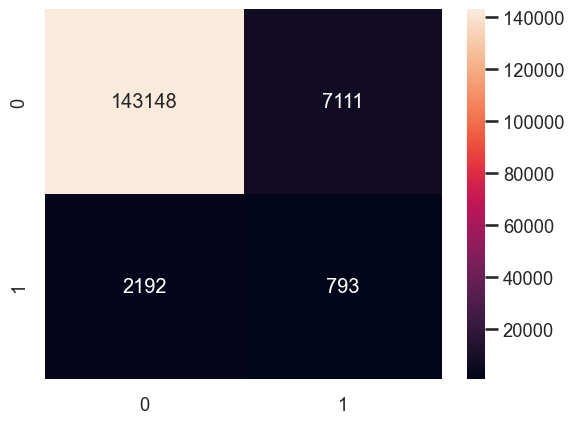

In [56]:
from sklearn.naive_bayes import GaussianNB
model_result = GaussianNB()
model_result.fit(X_train, y_train)


nbc_predictions = model_result.predict(X_test)
GaussianNB_aucroc_original = performance_of_model(y_test,nbc_predictions)

In [57]:
GaussianNB_aucroc_original

0.6091683446459611

Accuracy of model: 0.9944663412596905
Precision of model: 0.9688459850811759
Recall value: 0.7396984924623116
F1 Score: 0.8389057750759878
Area under the ROC Curve: 0.8696129875045571
Mean Absolute Error: 0.005533658740309572
Root Mean Squared Error: 0.07438856592453959


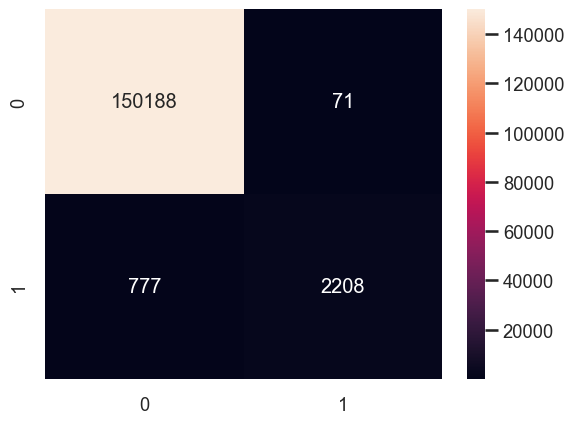

In [58]:
model_result = RandomForestClassifier(n_estimators=300, random_state=0)
model_result.fit(X_train, y_train)

rcf_predictions = model_result.predict(X_test)
rand_forest_aucroc_original = performance_of_model(y_test,rcf_predictions)

In [59]:
rand_forest_aucroc_original

0.8696129875045571

Accuracy of model: 0.9909882279240949
Precision of model: 0.7643375082399473
Recall value: 0.7768844221105528
F1 Score: 0.7705598936700448
Area under the ROC Curve: 0.8860629858507961
Mean Absolute Error: 0.009011772075905092
Root Mean Squared Error: 0.09493035381744394


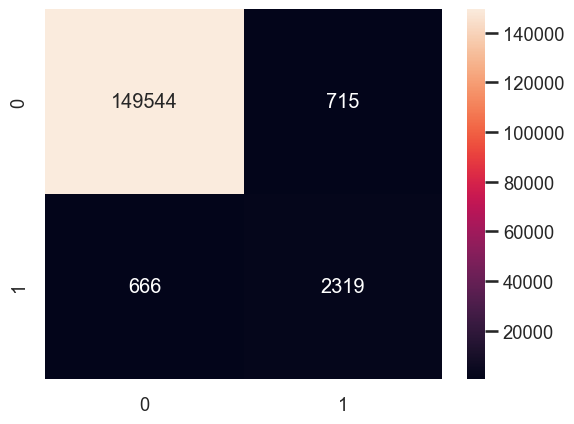

In [60]:
from sklearn.tree import DecisionTreeClassifier

model_result = DecisionTreeClassifier(random_state=0)

model_result.fit(X_train, y_train)

dt_predictions = model_result.predict(X_test)

deci_tree_aucroc_original = performance_of_model(y_test, dt_predictions)


In [61]:
deci_tree_aucroc_original

0.8860629858507961

# Under Sampling

In [62]:
X_s = imputed_new_copy_A_modified.drop('SepsisLabel', axis=1)
y_s = imputed_new_copy_A_modified['SepsisLabel']
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size=0.2)

In [63]:
train_data = pd.concat([X_train_s, y_train_s], axis=1)

In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split


train_data = pd.concat([X_train_s, y_train_s], axis=1)

minority_class_len = len(train_data[train_data['SepsisLabel'] == 1])
majority_class_indices = train_data[train_data['SepsisLabel'] == 0].index
random_majority_indices = np.random.choice(majority_class_indices, minority_class_len, replace=False)
minority_class_indices = train_data[train_data['SepsisLabel'] == 1].index
under_sample_indices = np.concatenate([minority_class_indices, random_majority_indices])
under_sample = train_data.loc[under_sample_indices]

X_train_s = under_sample.drop('SepsisLabel', axis=1)
y_train_s = under_sample['SepsisLabel']


24410
Accuracy of model: 0.8758646341781734
Precision of model: 0.07640807651434645
Recall value: 0.4670347515427087
F1 Score: 0.13133019772592358
Area under the ROC Curve: 0.6756410397409878
Mean Absolute Error: 0.12413536582182663
Root Mean Squared Error: 0.3523284913568964


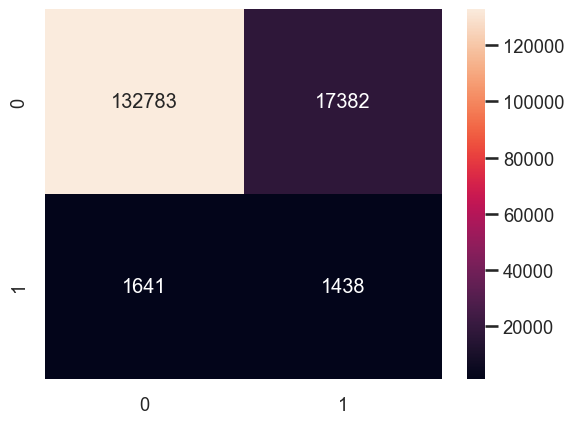

In [65]:
from sklearn.naive_bayes import GaussianNB
model_result_s = GaussianNB()
model_result_s.fit(X_train_s, y_train_s)

print(len(y_train_s))


nbc_predictions_s = model_result_s.predict(X_test_s)
GaussianNB_aucroc_undersampling = performance_of_model(y_test_s,nbc_predictions_s)

In [66]:
GaussianNB_aucroc_undersampling

0.6756410397409878

Accuracy of model: 0.923168280650466
Precision of model: 0.20475382003395587
Recall value: 0.9792140305293927
F1 Score: 0.3386879352954392
Area under the ROC Curve: 0.9506165714195925
Mean Absolute Error: 0.07683171934953408
Root Mean Squared Error: 0.2771853519750531


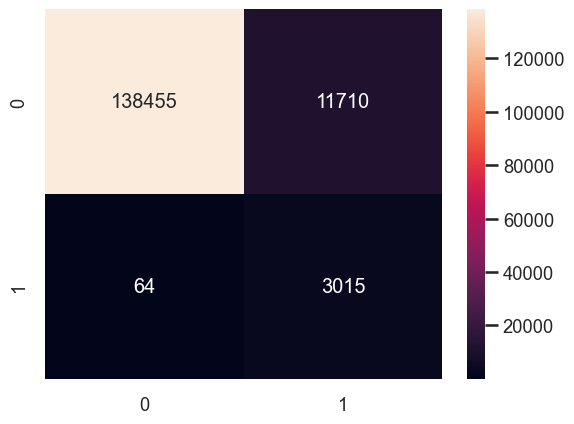

In [67]:
model_result_s = RandomForestClassifier(n_estimators=300, random_state=0)
model_result_s.fit(X_train_s, y_train_s)

rcf_predictions_s = model_result_s.predict(X_test_s)
rand_forest_aucroc_undersampling=performance_of_model(y_test_s,rcf_predictions_s)

In [68]:
rand_forest_aucroc_undersampling

0.9506165714195925

Accuracy of model: 0.826583748792775
Precision of model: 0.09675979954692113
Recall value: 0.9155569990256577
F1 Score: 0.1750225064414988
Area under the ROC Curve: 0.8701582151589515
Mean Absolute Error: 0.1734162512072251
Root Mean Squared Error: 0.41643276913233557


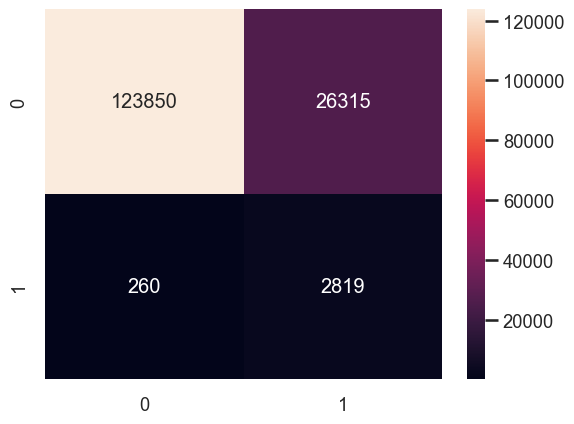

In [69]:
from sklearn.tree import DecisionTreeClassifier

model_result = DecisionTreeClassifier(random_state=0)

model_result.fit(X_train_s, y_train_s)

dt_predictions = model_result.predict(X_test_s)

deci_tree_aucroc_undersampling=performance_of_model(y_test_s, dt_predictions)


In [70]:
deci_tree_aucroc_undersampling

0.8701582151589515

# Over Sampling

In [71]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X_so = imputed_new_copy_A_modified.drop('SepsisLabel', axis=1)
y_so = imputed_new_copy_A_modified['SepsisLabel']
X_train_so, X_test_so, y_train_so, y_test_so = train_test_split(X_so, y_so, test_size=0.2)

sm = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = sm.fit_resample(X_train_so, y_train_so)



Accuracy of model: 0.9239839732713842
Precision of model: 0.2061813467967524
Recall value: 0.9953886693017128
F1 Score: 0.34160402419035774
Area under the ROC Curve: 0.958964706402028
Mean Absolute Error: 0.07601602672861581
Root Mean Squared Error: 0.2757100410369847


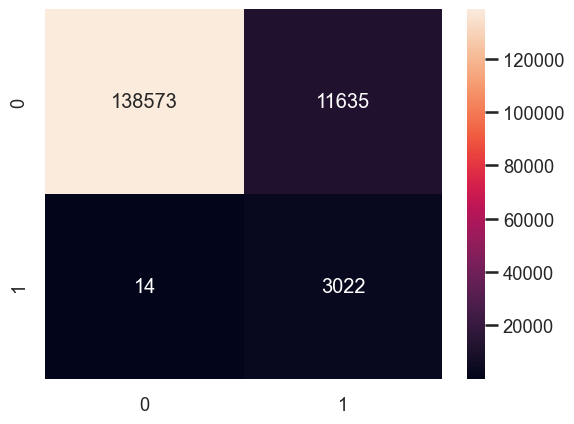

In [72]:
from sklearn.naive_bayes import GaussianNB
model_result_so = GaussianNB()
model_result_so.fit(X_train_resampled, y_train_resampled)


nbc_predictions_so = model_result_s.predict(X_test_so)
GaussianNB_aucroc_oversampling =performance_of_model(y_test_so,nbc_predictions_so)

In [73]:
GaussianNB_aucroc_oversampling

0.958964706402028

Accuracy of model: 0.8786249380073609
Precision of model: 0.07623611413635374
Recall value: 0.461133069828722
F1 Score: 0.1308411214953271
Area under the ROC Curve: 0.6740981710455923
Mean Absolute Error: 0.12137506199263919
Root Mean Squared Error: 0.34838923920327847


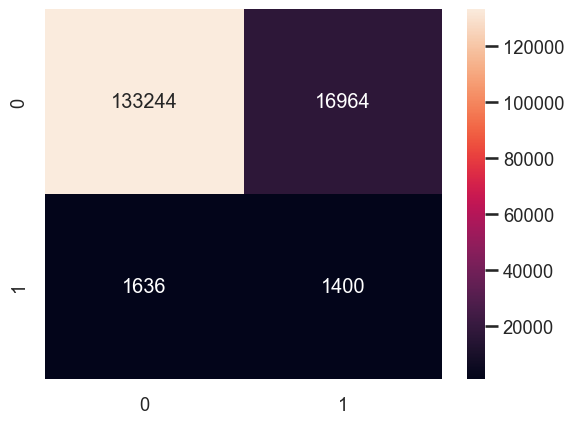

In [74]:
model_result_s = RandomForestClassifier(n_estimators=300, random_state=0)
model_result_so.fit(X_train_resampled, y_train_resampled)

rcf_predictions_so = model_result_so.predict(X_test_so)
rand_forest_aucroc_oversampling=performance_of_model(y_test_so,rcf_predictions_so)

In [75]:
rand_forest_aucroc_oversampling

0.6740981710455923

Accuracy of model: 0.9788572472657984
Precision of model: 0.4745254745254745
Recall value: 0.6258234519104084
F1 Score: 0.5397727272727272
Area under the ROC Curve: 0.8059081043105515
Mean Absolute Error: 0.021142752734201666
Root Mean Squared Error: 0.14540547697456813


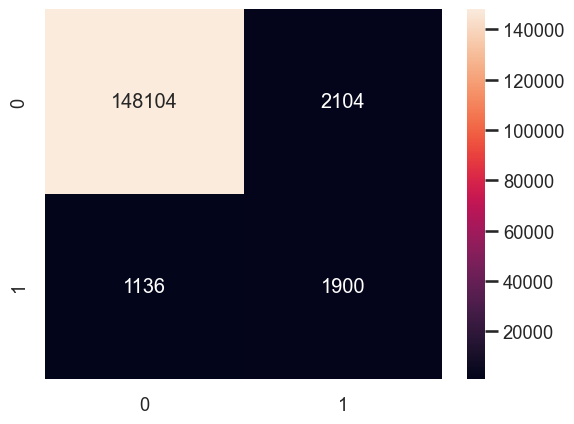

In [76]:
from sklearn.tree import DecisionTreeClassifier

model_result = DecisionTreeClassifier(random_state=0)

model_result.fit(X_train_resampled, y_train_resampled)

dt_predictions = model_result.predict(X_test_so)

deci_tree_aucroc_oversampling=performance_of_model(y_test_so, dt_predictions)

In [77]:
deci_tree_aucroc_oversampling

0.8059081043105515

In [78]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

In [79]:
dt = DecisionTreeClassifier(random_state=0)
rf = RandomForestClassifier(n_estimators=300, random_state=0)
gnb = GaussianNB()

In [80]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X_so = imputed_new_copy_A_modified.drop('SepsisLabel', axis=1)
y_so = imputed_new_copy_A_modified['SepsisLabel']
X_train_so, X_test_so, y_train_so, y_test_so = train_test_split(X_so, y_so, test_size=0.2)

sm = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = sm.fit_resample(X_train_so, y_train_so)



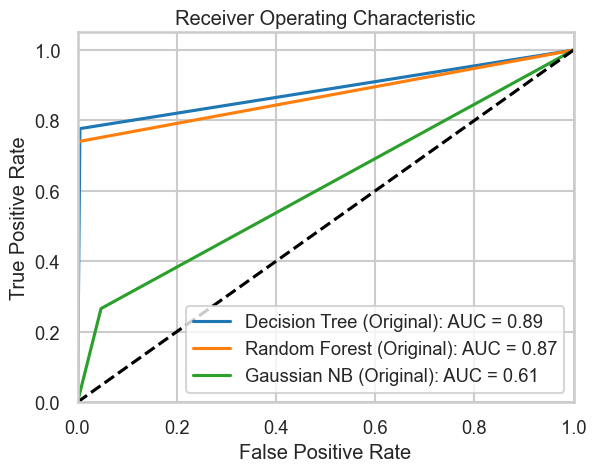

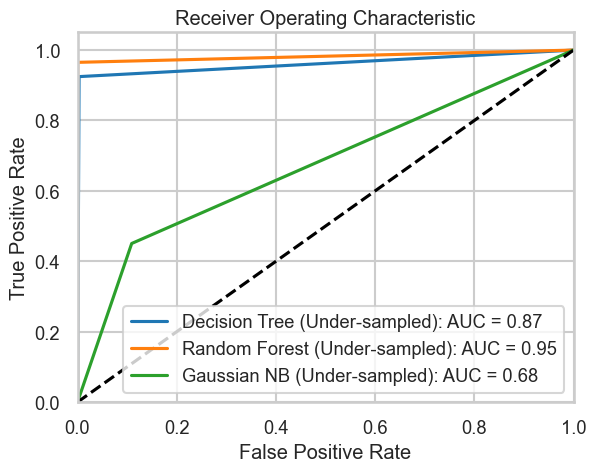

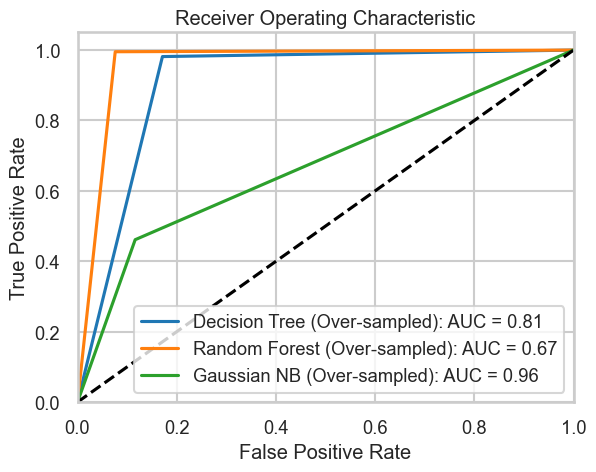

In [81]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

def model_train_predict(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_scores = model.predict(X_test)
    

    fpr, tpr, _ = roc_curve(y_test, y_scores)

    return fpr, tpr

precomputed_aucrocs = {
    'Decision Tree': {
        'Original': deci_tree_aucroc_original,
        'Under-sampled': deci_tree_aucroc_undersampling,
        'Over-sampled': deci_tree_aucroc_oversampling
    },
    'Random Forest': {
        'Original': rand_forest_aucroc_original,
        'Under-sampled': rand_forest_aucroc_undersampling,
        'Over-sampled': rand_forest_aucroc_oversampling
    },
    'Gaussian NB': {
        'Original': GaussianNB_aucroc_original,
        'Under-sampled': GaussianNB_aucroc_undersampling,
        'Over-sampled': GaussianNB_aucroc_oversampling
    }
  
}

for X, y, sampling_type in [(X_train, y_train, "Original"), 
                            (X_train_resampled, y_train_resampled, "Under-sampled"), 
                            (X_train_s, y_train_s, "Over-sampled")]:
    plt.figure()
    for model, name in [(dt, "Decision Tree"), (rf, "Random Forest"), (gnb, "Gaussian NB")]:
        fpr, tpr = model_train_predict(model, X, y, X_test, y_test)
        roc_auc = precomputed_aucrocs[name][sampling_type]
        plt.plot(fpr, tpr, label=f'{name} ({sampling_type}): AUC = {roc_auc:.2f}')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
